## 1번
* 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.
- 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 하이퍼파라미터 튜닝, 훈련 데이터 앙상블 학습 과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
(209, 10)
PRP                    1.000000
ERP                    0.966472
MMAX                   0.863004
MMIN                   0.794931
CACH                   0.662641
                         ...   
mname_v8655            0.002430
mname_as/6650          0.002324
mname_50-850-ii        0.001460
mname_as/7000-n        0.000269
mname_cyber:170/835    0.0001

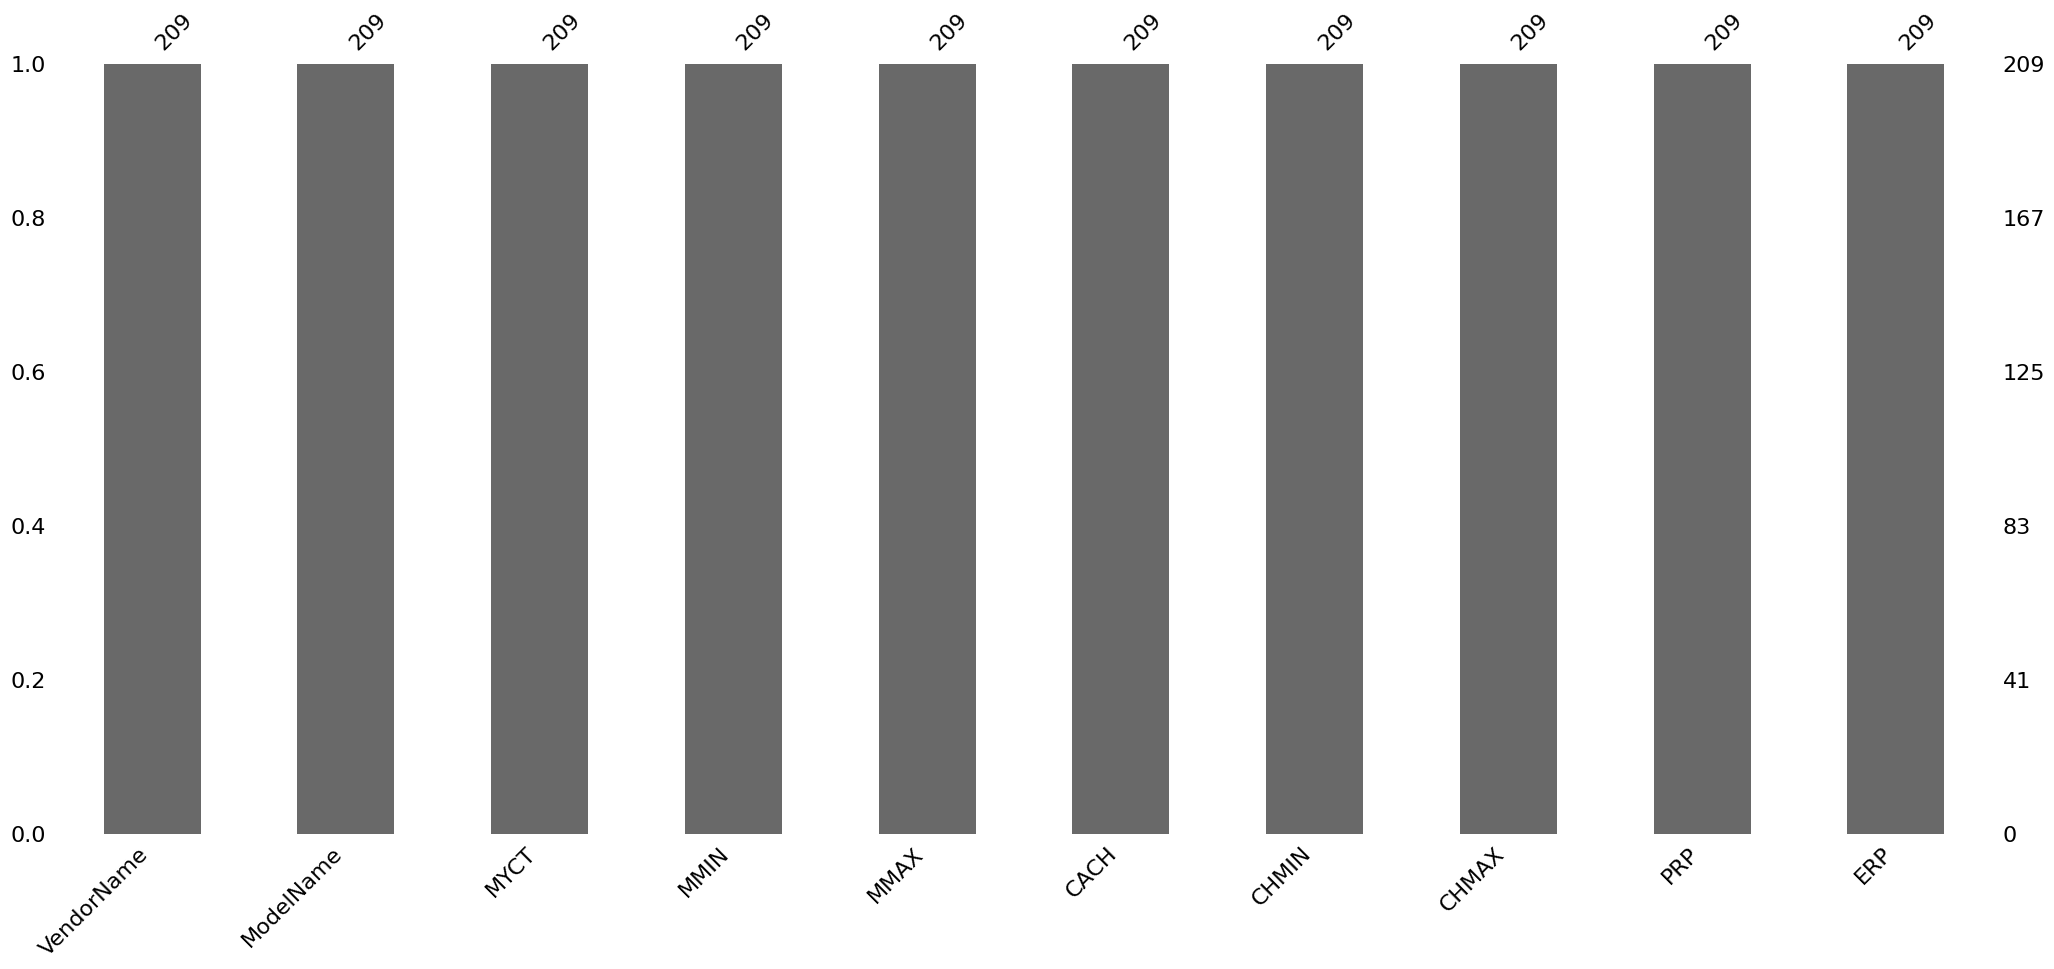

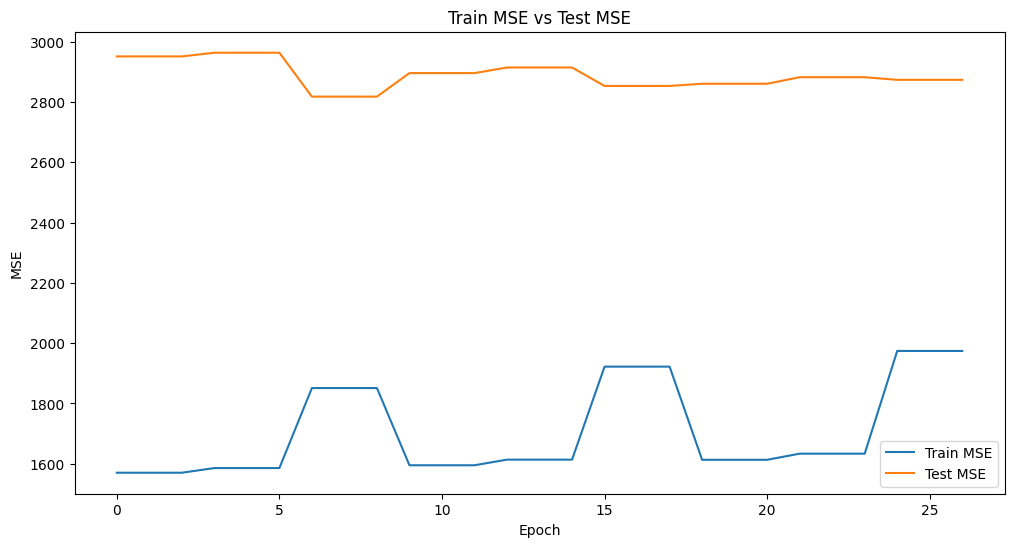

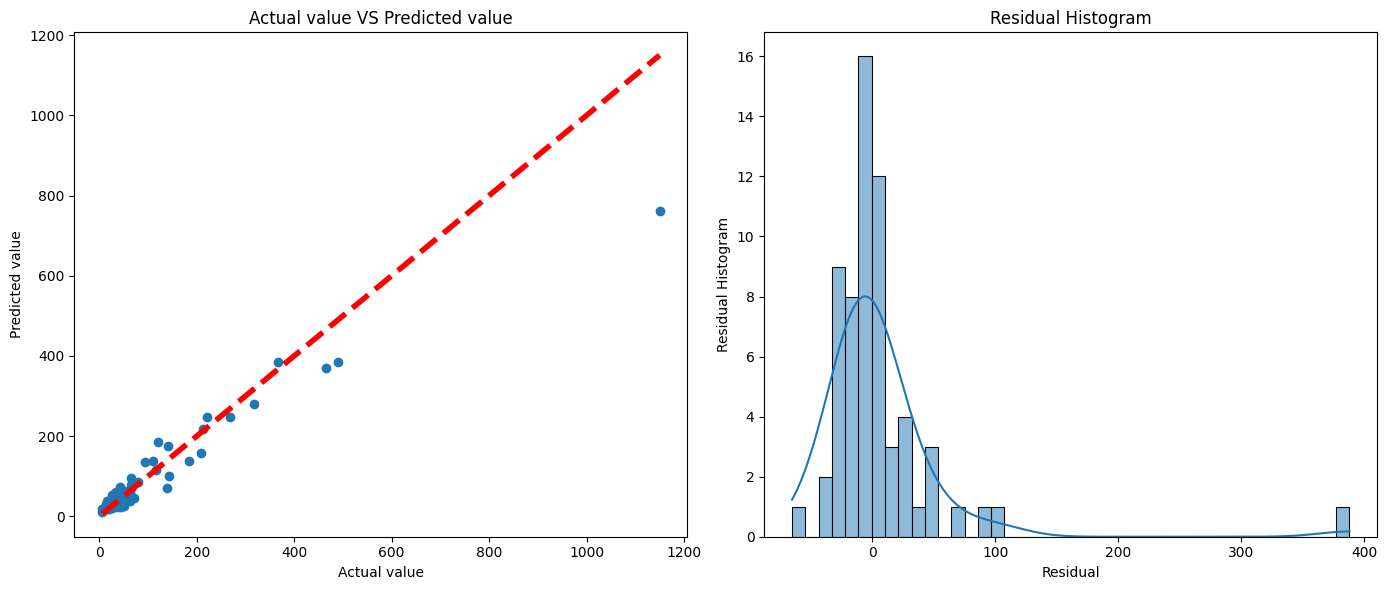

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 데이터셋 불러오기
db_model = pd.read_csv("machine.data_update.csv")

# 데이터셋 정보 출력
print(db_model.info())

# 데이터셋 형태 출력
print(db_model.shape)

# 데이터셋의 결측치 시각화
msn.bar(db_model)

# 결측치가 있는 행 제거
db_model.dropna(inplace=True)

# 'VendorName' 열을 원-핫 인코딩하고, 원본 데이터프레임에 병합
db_dummie = pd.get_dummies(db_model.VendorName, prefix='vname', dtype=float)
db_model = pd.concat([db_model.drop("VendorName", axis=1), db_dummie], axis=1)

# 'ModelName' 열을 원-핫 인코딩하고, 원본 데이터프레임에 병합
db_dummie = pd.get_dummies(db_model["ModelName"], prefix='mname', dtype=float)
db_model = pd.concat([db_model.drop("ModelName", axis=1), db_dummie], axis=1)

# 업데이트된 데이터프레임의 첫 몇 행 출력
db_model.head()

# 대상 변수 'PRP'와의 절대 상관관계를 계산
corr_PRP = db_model.corr()["PRP"]
corr_PRP = np.abs(corr_PRP)
print(corr_PRP.sort_values(ascending=False))

# 모델에 사용할 수치형 특징 선택
Number_feat = ['MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'ERP']

# 대상 변수 'y'와 특징 변수 'X' 정의
y = db_model["PRP"]
X = db_model[Number_feat]

# 데이터셋을 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# 수치형 특징 변환을 위한 파이프라인 생성
Number_transformer = Pipeline(steps=[('scaler', StandardScaler()),])

# 변환기를 결합하여 전처리기 생성
preprocessor = ColumnTransformer(transformers=[('num', Number_transformer, Number_feat),])

# 앙상블에 사용할 모델 목록 정의
models = [('lr', LinearRegression()),
          ('sgd', SGDRegressor(random_state=42)),
          ('ridge', Ridge(random_state=42))]

# 투표 회귀 앙상블 모델 생성
ensemble = VotingRegressor(estimators=models)

# 전처리 및 앙상블 모델을 포함하는 파이프라인 생성
model_pipeline = Pipeline(steps=[('pre', preprocessor), ('ensemble', ensemble)])

# 그리드 서치에서 사용할 하이퍼파라미터 정의
para =      {'ensemble__sgd__alpha': [0.0001, 0.01, 1.0],
             'ensemble__sgd__max_iter': [1000, 2000, 3000],
             'ensemble__ridge__alpha': [10, 20, 30]}

# 파이프라인과 하이퍼파라미터를 사용하여 GridSearchCV 초기화
grid = GridSearchCV(model_pipeline, para, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

# 그리드 서치를 사용하여 훈련 데이터에 모델 적합
grid.fit(X_train, y_train)

# 그리드 서치에서 최적의 추정기 가져오기
best_model = grid.best_estimator_

# 교차 검증 수행 및 평균 제곱 오차 계산
CVs = cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
CVS_mse = -CVs.mean()
print(f"교차검증 mse: {CVS_mse}")

# 테스트 세트에 대해 대상 변수 예측
y_pred = best_model.predict(X_test)

# 그리드 서치 결과를 저장할 데이터프레임 생성
results = pd.DataFrame(grid.cv_results_)

# 파라미터 세트(에폭)에 따른 훈련 및 테스트 MSE 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(results['mean_train_score'])), -results['mean_train_score'], label='Train MSE')
plt.plot(range(len(results['mean_test_score'])), -results['mean_test_score'], label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train MSE vs Test MSE')
plt.legend()
plt.show()

# 실제 값 대 예측 값 및 잔차 시각화
plt.figure(figsize=(14, 6))

# 실제 값 대 예측 값 산점도
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.title('Actual value VS Predicted value')

# 잔차 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel('Residual')
plt.ylabel('Residual Histogram')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()


## 2번
* (1) 단계에서 얻은 Pipeline 기반 모델 GridSearchCV의 best_estimator모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오.
- Mean squared Error, Mean absolute Error, R^2, 교차검증

In [12]:
# 교차 검증을 통해 MSE (평균 제곱 오차) 계산
CVS_mse = cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
CVS_mse = -CVS_mse.mean()

# 교차 검증을 통해 MAE (평균 절대 오차) 계산
CVS_mae = cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
CVS_mae = -CVS_mae.mean()

# 교차 검증을 통해 R^2 (결정 계수) 계산
CVS_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2")
CVS_r2 = CVS_r2.mean()

# 교차 검증 결과 출력
print(f"교차검증 결과 - MSE: {CVS_mse}, MAE: {CVS_mae}, R^2: {CVS_r2}")

# 훈련 데이터에 대해 예측값 계산
y_train_pred = best_model.predict(X_train)

# 훈련 데이터에 대한 MSE 계산
mse_train = mean_squared_error(y_train, y_train_pred)

# 훈련 데이터에 대한 MAE 계산
mae_train = mean_absolute_error(y_train, y_train_pred)

# 훈련 데이터에 대한 R^2 계산
r2_train = r2_score(y_train, y_train_pred)

# 훈련 데이터에 대한 성능 평가 결과 출력
print(f"훈련 데이터 성능 - MSE: {mse_train}, MAE: {mae_train}, R^2: {r2_train}")

# 테스트 데이터에 대해 MSE 계산
mse_test = mean_squared_error(y_test, y_pred)

# 테스트 데이터에 대해 MAE 계산
mae_test = mean_absolute_error(y_test, y_pred)

# 테스트 데이터에 대해 R^2 계산
r2_test = r2_score(y_test, y_pred)

# 테스트 데이터에 대한 성능 평가 결과 출력
print(f"테스트 데이터 성능  MSE: {mse_test}, MAE: {mae_test}, R^2: {r2_test}")

교차검증 결과 - MSE: 2817.4696470383433, MAE: 29.45977391560381, R^2: 0.7037795141262023
훈련 데이터 성능 - MSE: 1974.6323542729733, MAE: 26.334692842248526, R^2: 0.9193955830184029
테스트 데이터 성능  MSE: 3220.4077705253135, MAE: 25.844552350165678, R^2: 0.8873513344554873


## 3번
* (2) 단계에서 얻은 Pipeline 기반 GridSearchCV의 best_estimator모델의 테스트 데이터에 대해 예측 성능 R^2가 85% 이상이 나오도록 모델을 개선하시오.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 불러오기
db_model = pd.read_csv("machine.data_update.csv")
# 결측치가 있는 행 제거
db_model.dropna(inplace=True)

# 데이터셋 정보 출력
print(db_model.info())
# 데이터셋 크기 출력
print(db_model.shape)
# 결측치 시각화
msn.bar(db_model)

# 'VendorName' 열을 원-핫 인코딩하고 원본 데이터프레임에 병합
db_dummie = pd.get_dummies(db_model.VendorName, prefix='vname', dtype=float)
db_model = pd.concat([db_model.drop("VendorName", axis=1), db_dummie], axis=1)

# 'ModelName' 열을 원-핫 인코딩하고 원본 데이터프레임에 병합
db_dummie = pd.get_dummies(db_model["ModelName"], prefix='mname', dtype=float)
db_model = pd.concat([db_model.drop("ModelName", axis=1), db_dummie], axis=1)

# 첫 몇 개의 행 출력
db_model.head()

# 'PRP'와의 절대 상관관계 계산
corr_PRP = db_model.corr()["PRP"]
corr_PRP = np.abs(corr_PRP)
print(corr_PRP.sort_values(ascending=False))

# 특징 선택
Number_feat = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'ERP']

# 특징과 타겟 변수 정의
y = db_model["PRP"]
X = db_model[Number_feat]

# 데이터셋 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# 수치형 특징에 대해 표준화 전처리 파이프라인 생성
Number_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 전처리기를 구성
preprocessor = ColumnTransformer(transformers=[
    ('num', Number_transformer, Number_feat)
])

# 개별 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor(random_state=42)),
    ('ridge', Ridge(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]

# 앙상블 모델 생성
ensemble = VotingRegressor(estimators=models)

# 전처리기와 앙상블 모델을 연결하는 파이프라인 생성
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# 하이퍼파라미터 그리드 정의
para = {
    'ensemble__sgd__max_iter': [1000, 2000], 
    'ensemble__sgd__alpha': [0.001, 0.01],
    'ensemble__ridge__alpha': [10, 20], 
    'ensemble__gbr__n_estimators': [100, 200],  
    'ensemble__gbr__learning_rate': [0.01, 0.1]
}

# 그리드 서치를 설정 및 모델 학습
grid = GridSearchCV(model_pipeline, para, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# 그리드 서치로 훈련 데이터에 모델 적합
grid.fit(X_train, y_train)
# 최적 모델 저장
best_model = grid.best_estimator_

# 교차 검증을 통해 MSE 계산
CVS_mse = cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
CVS_mse = -CVS_mse.mean()

# 교차 검증을 통해 MAE 계산
CVS_mae = cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
CVS_mae = -CVS_mae.mean()

# 교차 검증을 통해 R^2 계산
CVS_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring="r2")
CVS_r2 = CVS_r2.mean()

# 교차 검증 결과 출력
print(f"교차검증 결과  MSE: {CVS_mse}, MAE: {CVS_mae}, R^2: {CVS_r2}")

# 테스트 데이터에 대한 예측 수행
y_pred = best_model.predict(X_test)
# 훈련 데이터에 대한 예측 수행
y_train_pred = best_model.predict(X_train)

# 훈련 데이터에 대한 MSE 계산
mse_train = mean_squared_error(y_train, y_train_pred)
# 훈련 데이터에 대한 MAE 계산
mae_train = mean_absolute_error(y_train, y_train_pred)
# 훈련 데이터에 대한 R^2 계산
r2_train = r2_score(y_train, y_train_pred)

# 훈련 데이터 성능 평가 결과 출력
print(f"Train MSE: {mse_train}")
print(f"Train MAE: {mae_train}")
print(f"Train R^2: {r2_train}")

# 테스트 데이터에 대한 MSE 계산
mse_test = mean_squared_error(y_test, y_pred)
# 테스트 데이터에 대한 MAE 계산
mae_test = mean_absolute_error(y_test, y_pred)
# 테스트 데이터에 대한 R^2 계산
r2_test = r2_score(y_test, y_pred)

# 테스트 데이터 성능 평가 결과 출력
print(f"Test MSE: {mse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test R^2: {r2_test}")

# GridSearchCV 결과를 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(grid.cv_results_['mean_train_score'])), -grid.cv_results_['mean_train_score'], label='Train MSE')
plt.plot(range(len(grid.cv_results_['mean_test_score'])), -grid.cv_results_['mean_test_score'], label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train MSE vs Test MSE')
plt.legend()
plt.show()

# 실제 값 대 예측 값 시각화
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Actual Value vs Predicted Value')

# 잔차 히스토그램 시각화
plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
(209, 10)
PRP                    1.000000
ERP                    0.966472
MMAX                   0.863004
MMIN                   0.794931
CACH                   0.662641
                         ...   
mname_v8655            0.002430
mname_as/6650          0.002324
mname_50-850-ii        0.001460
mname_as/7000-n        0.000269
mname_cyber:170/835    0.0001

## 4번
* 3차 프로그래밍 과제의 기본모델의 (2) 단계와 II. 4차 프로그래밍 과제의 제안 모델의 (2) 단계에서 얻은 학습 데이터와 테스트 데이터에 대한 성능 지표(MSE, MAE, R^2, 교차 검증)를 데이터프레임에 저장하여 이 성능 결과를 바 차트로 시각화하여 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이를 비교 분석하시오.

               Model              Data          MSE        MAE       R^2
0  Linear Regression             Train  1641.531000  24.442695  0.932993
1  Linear Regression              Test  1850.745114  23.545205  0.935262
2  Linear Regression  Cross Validation  3171.781469  30.708239  0.700036
3     Best_estimator             Train   993.433675  18.888757  0.959448
4     Best_estimator              Test  1978.727017  22.808779  0.930785
5     Best_estimator  Cross Validation  2706.117551  28.639421  0.733903


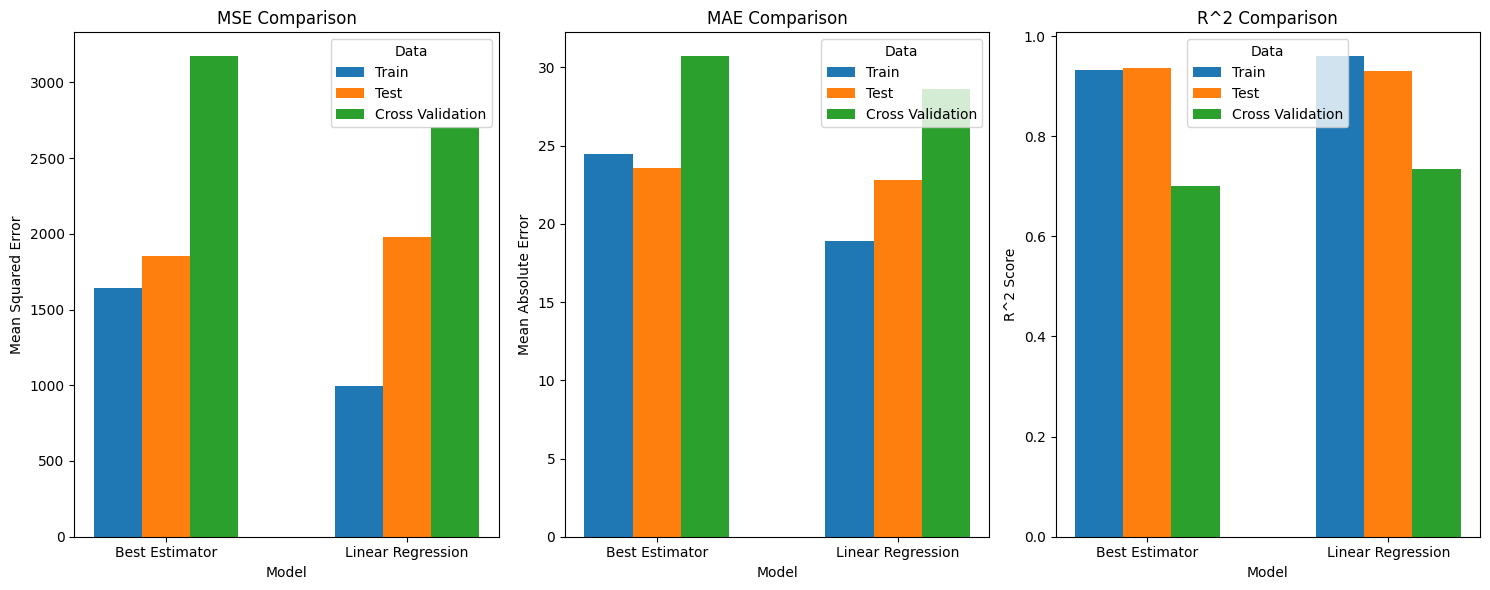

In [10]:
# 모델 결과를 저장한 CSV 파일을 읽어옴
df = pd.read_csv('model_result.csv')

# 새로운 데이터 생성
data    = {'Model': ['Best_estimator', 'Best_estimator', 'Best_estimator'],
            'Data': ['Train', 'Test', 'Cross Validation'],
            'MSE': [mse_train, mse_test, CVS_mse],
            'MAE': [mae_train, mae_test, CVS_mae],
            'R^2': [r2_train, r2_test, CVS_r2]}

# 새로운 데이터를 데이터프레임으로 변환
df2 = pd.DataFrame(data)

# 기존 데이터프레임과 새로운 데이터를 병합
df = pd.concat([df, df2], ignore_index=True)

# 병합된 데이터프레임 출력
print(df)

# 성능 지표(MSE, MAE, R^2)를 리스트로 변환
MSE = df['MSE'].values.tolist()
MAE = df['MAE'].values.tolist()
R2 = df['R^2'].values.tolist()

# 각 모델의 테스트 데이터 MSE 추출
Test_mse = [MSE[1], MSE[4]]
# 각 모델의 학습 데이터 MSE 추출
Train_mse = [MSE[0], MSE[3]]
# 각 모델의 교차 검증 MSE 추출
CVS_mse = [MSE[2], MSE[5]]

# 각 모델의 테스트 데이터 MAE 추출
Test_mae = [MAE[1], MAE[4]]
# 각 모델의 학습 데이터 MAE 추출
Train_mae = [MAE[0], MAE[3]]
# 각 모델의 교차 검증 MAE 추출
CVS_mae = [MAE[2], MAE[5]]

# 각 모델의 테스트 데이터 R^2 추출
Test_r2 = [R2[1], R2[4]]
# 각 모델의 학습 데이터 R^2 추출
Train_r2 = [R2[0], R2[3]]
# 각 모델의 교차 검증 R^2 추출
CVS_r2 = [R2[2], R2[5]]

# 모든 성능 지표를 포함하는 딕셔너리 생성
all = {'train_ms': Train_mse,
       'test_ms': Test_mse,
       'cv_ms': CVS_mse,
       'train_ma': Train_mae,
       'test_ma': Test_mae,
       'cv_ma': CVS_mae,
       'train_r2': Train_r2,
       'test_r2': Test_r2,
       'cv_r2': CVS_r2}

# 성능 지표 딕셔너리를 데이터프레임으로 변환
new_df = pd.DataFrame(all)

# 인덱스 설정 (모델 개수만큼의 범위)
index = np.arange(2)

# 그림 사이즈 설정 및 서브플롯 생성
_, s_p = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# 첫 번째 서브플롯: MSE 비교
s_p[0].bar(index-0.2, new_df['train_ms'], width=0.2, label='Train')
s_p[0].bar(index, new_df['test_ms'], width=0.2, label='Test')
s_p[0].bar(index+0.2, new_df['cv_ms'], width=0.2, label='Cross Validation')
s_p[0].set_xticks(index)
s_p[0].set_xticklabels(['Best Estimator', 'Linear Regression'])
s_p[0].set_title('MSE Comparison')
s_p[0].legend(title='Data')
s_p[0].set_xlabel('Model')
s_p[0].set_ylabel('Mean Squared Error')

# 두 번째 서브플롯: MAE 비교
s_p[1].bar(index-0.2, new_df['train_ma'], width=0.2, label='Train')
s_p[1].bar(index, new_df['test_ma'], width=0.2, label='Test')
s_p[1].bar(index+0.2, new_df['cv_ma'], width=0.2, label='Cross Validation')
s_p[1].set_xticks(index)
s_p[1].set_xticklabels(['Best Estimator', 'Linear Regression'])
s_p[1].set_title('MAE Comparison')
s_p[1].set_xlabel('Model')
s_p[1].set_ylabel('Mean Absolute Error')
s_p[1].legend(title='Data')

# 세 번째 서브플롯: R^2 비교
s_p[2].bar(index-0.2, new_df['train_r2'], width=0.2, label='Train')
s_p[2].bar(index, new_df['test_r2'], width=0.2, label='Test')
s_p[2].bar(index+0.2, new_df['cv_r2'], width=0.2, label='Cross Validation')
s_p[2].set_xticks(index)
s_p[2].set_xticklabels(['Best Estimator', 'Linear Regression'])
s_p[2].set_title('R^2 Comparison')
s_p[2].set_xlabel('Model')
s_p[2].set_ylabel('R^2 Score')
s_p[2].legend(title='Data')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()